<a href="https://colab.research.google.com/github/Seiko-5/NLP/blob/main/AFL_Tweet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use of Advanced NLP Techniques to Analyse the data

## 01. Loading Libraries



In [ ]:
!pip install pyLDAvis

In [ ]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import files

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#load in the sentiment analyzer
sia=SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## 02. Load Data

In [ ]:
df= pd.read_csv ('/content/TweetExtraction02.csv')

## 03. Preliminary Analysis

### 03.01. SUMMSUMMARY OF THE DATA SET

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 90 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  1392 non-null   object 
 1   status_id                1392 non-null   object 
 2   created_at               1392 non-null   object 
 3   screen_name              1392 non-null   object 
 4   text                     1392 non-null   object 
 5   source                   1392 non-null   object 
 6   display_text_width       1392 non-null   int64  
 7   reply_to_status_id       60 non-null     object 
 8   reply_to_user_id         92 non-null     object 
 9   reply_to_screen_name     92 non-null     object 
 10  is_quote                 1392 non-null   bool   
 11  is_retweet               1392 non-null   bool   
 12  favorite_count           1392 non-null   int64  
 13  retweet_count            1392 non-null   int64  
 14  quote_count             

As the first step, we can select a subset of columns required for our analysis. This can be done based on your business requirement.

In [ ]:
df = df[['created_at', 'text', 'quoted_location', 'location']]

### 03.02. WORD COUNT


In [ ]:
def word_counter(document):
  split_word = str(document).split(" ") # split by white space
  word_count = len(split_word) # count the words
  return word_count

df['word_count_function'] = df['text'].apply(word_counter)

In [ ]:
df.head(5)

,created_at,text,quoted_location,location,word_count_function
0,2020-10-25 02:04:34,The world’s most successful sporting events pr...,NaN,Melbourne,49
1,2020-10-25 02:00:40,"Night Grand Final was a failure, waste of a da...",NaN,"Melbourne, Australia",29
2,2020-10-17 05:16:24,"As Ej Whitten would say - ""We stuck it right u...","Swinburne Centre, Punt Road","Melbourne, Australia",15
3,2020-10-19 03:20:44,The best thing about last Friday's win was tha...,NaN,"Melbourne, Australia",36
4,2020-10-24 11:46:46,A thrilling Grand Final with Geelong and Richm...,NaN,"Melbourne, Australia",46


Same above function can be achieved through a simple lambda function.

In [ ]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df.head(5)

,created_at,text,quoted_location,location,word_count_function,word_count
0,2020-10-25 02:04:34,The world’s most successful sporting events pr...,NaN,Melbourne,49,49
1,2020-10-25 02:00:40,"Night Grand Final was a failure, waste of a da...",NaN,"Melbourne, Australia",29,29
2,2020-10-17 05:16:24,"As Ej Whitten would say - ""We stuck it right u...","Swinburne Centre, Punt Road","Melbourne, Australia",15,15
3,2020-10-19 03:20:44,The best thing about last Friday's win was tha...,NaN,"Melbourne, Australia",36,36
4,2020-10-24 11:46:46,A thrilling Grand Final with Geelong and Richm...,NaN,"Melbourne, Australia",46,46


### 03.03.CHARACCHARACTER COUNT

In [ ]:
df['char_count'] = df['text'].str.len()  # Includes the spaces
df.head(5)

,created_at,text,quoted_location,location,word_count_function,word_count,char_count
0,2020-10-25 02:04:34,The world’s most successful sporting events pr...,NaN,Melbourne,49,49,280
1,2020-10-25 02:00:40,"Night Grand Final was a failure, waste of a da...",NaN,"Melbourne, Australia",29,29,167
2,2020-10-17 05:16:24,"As Ej Whitten would say - ""We stuck it right u...","Swinburne Centre, Punt Road","Melbourne, Australia",15,15,94
3,2020-10-19 03:20:44,The best thing about last Friday's win was tha...,NaN,"Melbourne, Australia",36,36,208
4,2020-10-24 11:46:46,A thrilling Grand Final with Geelong and Richm...,NaN,"Melbourne, Australia",46,46,312


### 03.04. AVARAGE WORD LENGTH 




In [ ]:
def avg_word(sentence):
  words = sentence.split() # split the sentence into words
  avg_of_words = (sum(len(word) for word in words)/len(words))
  return avg_of_words

df['avg_word'] = df['text'].apply(avg_word)
df.head(5)

,created_at,text,quoted_location,location,word_count_function,word_count,char_count,avg_word
0,2020-10-25 02:04:34,The world’s most successful sporting events pr...,NaN,Melbourne,49,49,280,4.734694
1,2020-10-25 02:00:40,"Night Grand Final was a failure, waste of a da...",NaN,"Melbourne, Australia",29,29,167,4.793103
2,2020-10-17 05:16:24,"As Ej Whitten would say - ""We stuck it right u...","Swinburne Centre, Punt Road","Melbourne, Australia",15,15,94,5.333333
3,2020-10-19 03:20:44,The best thing about last Friday's win was tha...,NaN,"Melbourne, Australia",36,36,208,4.805556
4,2020-10-24 11:46:46,A thrilling Grand Final with Geelong and Richm...,NaN,"Melbourne, Australia",46,46,312,5.395833


## 04. Preprocessing

### 04.01.  Transform sentences into lowercase

In [ ]:
df['text'] = df['text'].str.lower()

In [ ]:
# Following command is just to visualize the processed dataframe
df.tail()

,created_at,text,quoted_location,location,word_count_function,word_count,char_count,avg_word
1387,2020-10-16 21:57:22,lions and tigers (and bears! <u+0001f606>). oh...,NaN,"Melbourne, Victoria",13,13,100,6.769231
1388,2020-10-16 20:02:20,anyone else see the resemblance? focus on foot...,NaN,Melbourne,16,16,121,6.625000
1389,2020-10-16 12:57:40,"brad ebert, maybe not right now, but one day y...",NaN,"Melbourne, Victoria, Australia",53,53,290,4.490566
1390,2020-10-16 12:44:49,"look, i think i’m at this stage of the season,...",NaN,"Melbourne, Victoria",32,32,192,5.000000
1391,2020-10-16 12:00:52,not sure putting the #afl and #nrl gf back to ...,NaN,"Melbourne, Australia",23,23,107,3.695652


Remove twitter user ids that are mentioned in the tweet text. We will use regular expressions(https://www.w3schools.com/python/python_regex.asp) to do this.
In applying the regular expression, we use the string in the format r"regular-expression". This is to treat the regex as a raw string. Additional information on this can be found from this stackoverflow question(https://stackoverflow.com/questions/4780088/what-does-preceding-a-string-literal-with-r-mean).

In [ ]:
def remove_twitter_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) # remove multiple spaces
  return spaces_removed

df['text'] = df['text'].apply(remove_twitter_ids)
df.tail()

,created_at,text,quoted_location,location,word_count_function,word_count,char_count,avg_word
1387,2020-10-16 21:57:22,lions and tigers and bears u0001f606 oh my afl...,NaN,"Melbourne, Victoria",13,13,100,6.769231
1388,2020-10-16 20:02:20,anyone else see the resemblance focus on footy...,NaN,Melbourne,16,16,121,6.625000
1389,2020-10-16 12:57:40,brad ebert maybe not right now but one day you...,NaN,"Melbourne, Victoria, Australia",53,53,290,4.490566
1390,2020-10-16 12:44:49,look i think im at this stage of the season th...,NaN,"Melbourne, Victoria",32,32,192,5.000000
1391,2020-10-16 12:00:52,not sure putting the afl and nrl gf back to ba...,NaN,"Melbourne, Australia",23,23,107,3.695652


In [ ]:
# How does above function works?
# Take any tweet that has mentions in it. e.g., https://twitter.com/DavidLKeating/status/1251253645431144457
twt = "Canada just ordered #masks4all for flights. We need this on all US flights NOW. What are we waiting for @SecElaineChao @AmericanAir @Delta @SouthwestAir @united @AlaskaAir @FAANews ??? @jeremyphoward update"
out_twt = remove_twitter_ids(twt)
print(out_twt)

Canada just ordered masks4all for flights We need this on all US flights NOW What are we waiting for update


### 04.02 Duplicate removal

In [ ]:
# Check duplicate tweets count
duplicate_count = len(df['text'])-len(df['text'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df.shape[0])

duplicate count: 5
total records before remove duplicates: 1392


### 04.03 Stop words and domain related word removal

In [ ]:
#Remove stop words
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# get the list of all stopwords from the library
stop = stopwords.words('english')

In [ ]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

removing the term 'not' from the stopword list for analysis.

In [ ]:
stop.remove('not')

In [ ]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [ ]:
# Remove the words in 'stop' list
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
df['text'] = df['text'].apply(remove_stop_words)
df.tail(5)

,created_at,text,quoted_location,location,word_count_function,word_count,char_count,avg_word
1387,2020-10-16 21:57:22,lions tigers bears u0001f606 oh afl aflfinals ...,NaN,"Melbourne, Victoria",13,13,100,6.769231
1388,2020-10-16 20:02:20,anyone else see resemblance focus footy ahead ...,NaN,Melbourne,16,16,121,6.625000
1389,2020-10-16 12:57:40,brad ebert maybe not right one day look back f...,NaN,"Melbourne, Victoria, Australia",53,53,290,4.490566
1390,2020-10-16 12:44:49,look think im stage season premiership favouri...,NaN,"Melbourne, Victoria",32,32,192,5.000000
1391,2020-10-16 12:00:52,not sure putting afl nrl gf back back smart id...,NaN,"Melbourne, Australia",23,23,107,3.695652


### 04.04 Remove digits

In [ ]:
def remove_digits(sent):
  return " ".join(w for w in sent.split() if not w.isdigit())

df['text'] = df['text'].apply(remove_digits)
df.head()

,created_at,text,quoted_location,location,word_count_function,word_count,char_count,avg_word
0,2020-10-25 02:04:34,worlds successful sporting events prioritise t...,NaN,Melbourne,49,49,280,4.734694
1,2020-10-25 02:00:40,night grand final failure waste day lack cover...,NaN,"Melbourne, Australia",29,29,167,4.793103
2,2020-10-17 05:16:24,ej whitten would say stuck right afl richmond,"Swinburne Centre, Punt Road","Melbourne, Australia",15,15,94,5.333333
3,2020-10-19 03:20:44,best thing last fridays win silenced kochie so...,NaN,"Melbourne, Australia",36,36,208,4.805556
4,2020-10-24 11:46:46,thrilling grand final geelong richmond neck am...,NaN,"Melbourne, Australia",46,46,312,5.395833


### 04.05 Spelling correction



To correct misspelt words, we will use [textblob library](https://textblob.readthedocs.io/en/dev/) library. Keep in mind that corrections are always bound by the dictionary that you would use, and it may not account for context (their vs there).

Due to the time complexity of spell-checking an entire corpus, in this exercise, we will use spell-check for just one example. 

In [ ]:
from textblob import TextBlob

In [ ]:
# Do not run this line of code.
# Following line of code will correct spellings of all the sentences in the dataset.
df['text'] = df['text'].apply(lambda x: str(TextBlob(x).correct()))   # This will take a long time. Thus, we will show an seperate example

Spelling correction example

In [ ]:
def correct_word(word):
  return str(TextBlob(word).correct())

print(correct_word('bisness'))

business


In [ ]:
incorrect_text = 'bisness anlytis is an itant skil seit for any organizaton'

func = lambda x: str(TextBlob(x).correct())
print(incorrect_text)
print(str(TextBlob(incorrect_text).correct()))

bisness anlytis is an itant skil seit for any organizaton
business analysis is an want skin set for any organization


## 05. Standardization of sentesentences 

### Stemming

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

df['text_stem'] = df['text'].apply(stemming_function)

In [ ]:
# Compare the content vs. stemmed content
df[['text', 'text_stem']].tail(10)

,text,text_stem
1382,ablest jar married childhood sweetheart feelin...,ablest jar marri childhood sweetheart feel lef...
1383,last three seasons team finished top ladder fa...,last three season team finish top ladder fail ...
1384,anyone tried turning nm all kangaroos,anyon tri turn nm all kangaroo
1385,also works daily numbers covid19vic all,also work daili number covid19v all
1386,u2705 making nrlgf u2705 ff making all of u261...,u2705 make nrlgf u2705 ff make all of u261dufe...
1387,lions tigers bears u0001f606 oh all aflfinals ...,lion tiger bear u0001f606 oh all aflfin cat
1388,anyone else see resemblance focus foot ahead t...,anyon els see resembl focu foot ahead time all...
1389,bad exert maybe not right one day look back fi...,bad exert mayb not right one day look back fin...
1390,look think in stage season premiership favouri...,look think in stage season premiership favouri...
1391,not sure putting all nl of back back smart ide...,not sure put all nl of back back smart idea we...


### Lemmatization



In [ ]:
# Download wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmtizer = WordNetLemmatizer()

In [ ]:
def lemmatize_function(sent):
  word_list = sent.split()
  lemma_word_list = [lemmtizer.lemmatize(word) for word in word_list]
  lemma_sentence = " ".join(lemma_word_list)
  return lemma_sentence

df['text_lemmatized'] = df['text'].apply(lemmatize_function)

Display original pre-processed sentence, stemmed sentence and lemmatized sentence.

In [ ]:
df[['text', 'text_stem', 'text_lemmatized']].tail(10)

,text,text_stem,text_lemmatized
1382,ablest jar married childhood sweetheart feelin...,ablest jar marri childhood sweetheart feel lef...,ablest jar married childhood sweetheart feelin...
1383,last three seasons team finished top ladder fa...,last three season team finish top ladder fail ...,last three season team finished top ladder fai...
1384,anyone tried turning nm all kangaroos,anyon tri turn nm all kangaroo,anyone tried turning nm all kangaroo
1385,also works daily numbers covid19vic all,also work daili number covid19v all,also work daily number covid19vic all
1386,u2705 making nrlgf u2705 ff making all of u261...,u2705 make nrlgf u2705 ff make all of u261dufe...,u2705 making nrlgf u2705 ff making all of u261...
1387,lions tigers bears u0001f606 oh all aflfinals ...,lion tiger bear u0001f606 oh all aflfin cat,lion tiger bear u0001f606 oh all aflfinals cat
1388,anyone else see resemblance focus foot ahead t...,anyon els see resembl focu foot ahead time all...,anyone else see resemblance focus foot ahead t...
1389,bad exert maybe not right one day look back fi...,bad exert mayb not right one day look back fin...,bad exert maybe not right one day look back fi...
1390,look think in stage season premiership favouri...,look think in stage season premiership favouri...,look think in stage season premiership favouri...
1391,not sure putting all nl of back back smart ide...,not sure put all nl of back back smart idea we...,not sure putting all nl of back back smart ide...


Lemmatized algorithm seems to be working better in this case.


## 06. Common and rare word analysis (Word Frequency Analysis)

### 06.01 Common Words

In [ ]:
# Create a word frequency series. 
word_frequency = pd.Series(' '.join(df['text_lemmatized']).split()).value_counts()

In [ ]:
# Look at the top 50 words 
word_frequency[:50]

all                  1374
aflgf                 307
final                 291
grand                 255
afltigerscats         220
aflfinals             190
year                  152
richmond              125
game                  122
aflgrandfinal         114
feeling               100
time                   97
afllionscats           96
go                     87
not                    87
player                 86
melbourne              85
day                    85
night                  83
tiger                  82
get                    79
cat                    79
of                     78
win                    77
one                    72
like                   70
back                   69
aflgrandfinal2020      67
victoria               65
foot                   65
good                   65
team                   65
dusty                  63
ff                     62
best                   62
brownlow               59
amp                    58
week                   53
can         

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


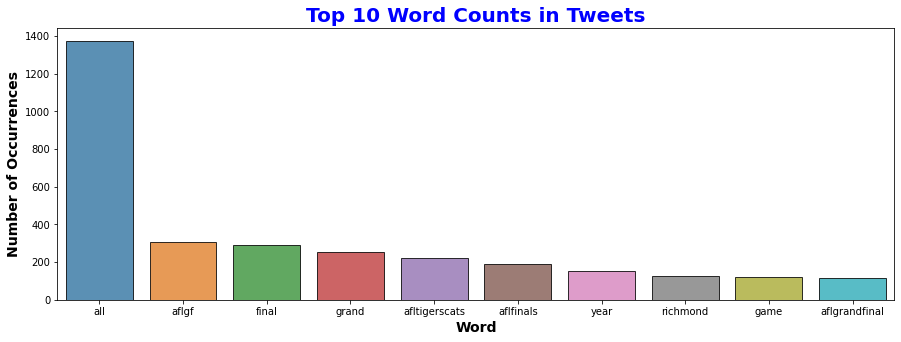

In [ ]:
# Visualize the top 10 word counts 

word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8,edgecolor = 'black')

plt.title('Top 10 Word Counts in Tweets',fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Occurrences', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.xlabel('Word', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.show()

We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words in 4

In [ ]:
from PIL import Image
from wordcloud import WordCloud

### 06.02. Remove common words

In [ ]:
# Creating a list of custom stopwords
new_words_to_remove = ["all", "well", "in","ff","of","go"]

In [ ]:
# Remove common Tweet
df['text_lemmatized'] = df['text_lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(5)

,created_at,text,quoted_location,location,word_count_function,word_count,char_count,avg_word,text_stem,text_lemmatized
0,2020-10-25 02:04:34,worlds successful sporting events prioritise t...,NaN,Melbourne,49,49,280,4.734694,world success sport event prioritis to exposur...,world successful sporting event prioritise to ...
1,2020-10-25 02:00:40,night grand final failure waste day lack cover...,NaN,"Melbourne, Australia",29,29,167,4.793103,night grand final failur wast day lack coverag...,night grand final failure waste day lack cover...
2,2020-10-17 05:16:24,e written would say stuck right all richmond,"Swinburne Centre, Punt Road","Melbourne, Australia",15,15,94,5.333333,e written would say stuck right all richmond,e written would say stuck right richmond
3,2020-10-19 03:20:44,best thing last friday win silenced sophie loo...,NaN,"Melbourne, Australia",36,36,208,4.805556,best thing last friday win silenc sophi look r...,best thing last friday win silenced sophie loo...
4,2020-10-24 11:46:46,thrilling grand final feeling richmond neck am...,NaN,"Melbourne, Australia",46,46,312,5.395833,thrill grand final feel richmond neck amp neck...,thrilling grand final feeling richmond neck am...


In [ ]:
# Create a word frequency series. 
word_frequency = pd.Series(' '.join(df['text_lemmatized']).split()).value_counts()

In [ ]:
# Look at the top 50 words
word_frequency[:50]

aflgf                307
final                291
grand                255
afltigerscats        220
aflfinals            190
year                 152
richmond             125
game                 122
aflgrandfinal        114
feeling              100
time                  97
afllionscats          96
not                   87
player                86
day                   85
melbourne             85
night                 83
tiger                 82
get                   79
cat                   79
win                   77
one                   72
like                  70
back                  69
aflgrandfinal2020     67
team                  65
foot                  65
good                  65
victoria              65
dusty                 63
best                  62
brownlow              59
amp                   58
week                  53
can                   52
dont                  51
want                  48
would                 48
brisbane              47
grandfinal            46


In [ ]:
# Save the pre-process data
# df1.to_csv('Preprocess_Tweets.csv')

### 06.03.Word Cloud

In this Word Cloud frequency of all the worlds were taken in to consideration.

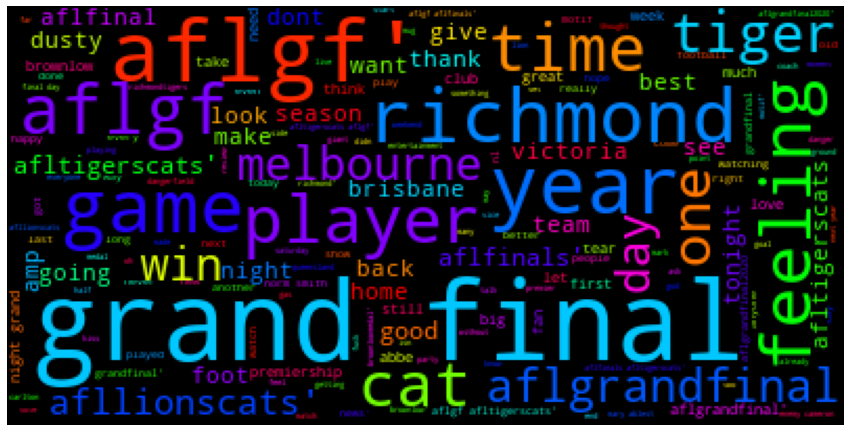

In [ ]:
corpus = list(df['text_lemmatized'])

wordcloud = WordCloud(background_color='black',colormap="hsv",
                      random_state=42).generate(str(corpus))

fig = plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('Word_Cloud_01.png', dpi=800)
#files.download('Word_Cloud_01.png')
plt.show()

### 06.04. Rare Words

In [ ]:
word_frequency[-50:]

trilogy                                 1
pleaseour                               1
lockdownmelbourne                       1
dew                                     1
u0001f64c                               1
ignoring                                1
ratugolea                               1
victory                                 1
paul                                    1
genderbias                              1
enoughaflgf                             1
er                                      1
following                               1
argument                                1
everett                                 1
jr                                      1
cherry                                  1
aflmoneyball                            1
u0001f923u0001f923u0001f923u0001f923    1
fishing                                 1
peasant                                 1
yyyyyyeeehhhssssaflgf                   1
akermanis                               1
back2back                         

### 06.05. Remove Rare words

In [ ]:
# Creating a list of custom stopwords
new_words_to_remove = ["u0001f42fu0001f431never", "u0001f644u0001f644u0001f644", "onlinelearning","u0001f4faauspol","u0001f923u0001f923u0001f923u0001f923","yyyyyyeeehhhssssaflgf","u0001f44du0001f3fcafl","deanu0001f399ufe0f","u0001f4ce","u0001f610afl"]

In [ ]:
# Remove common Tweet
df['text_lemmatized'] = df['text_lemmatized'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(5)

,created_at,text,quoted_location,location,word_count_function,word_count,char_count,avg_word,text_stem,text_lemmatized
0,2020-10-25 02:04:34,worlds successful sporting events prioritise t...,NaN,Melbourne,49,49,280,4.734694,world success sport event prioritis to exposur...,world successful sporting event prioritise to ...
1,2020-10-25 02:00:40,night grand final failure waste day lack cover...,NaN,"Melbourne, Australia",29,29,167,4.793103,night grand final failur wast day lack coverag...,night grand final failure waste day lack cover...
2,2020-10-17 05:16:24,e written would say stuck right all richmond,"Swinburne Centre, Punt Road","Melbourne, Australia",15,15,94,5.333333,e written would say stuck right all richmond,e written would say stuck right richmond
3,2020-10-19 03:20:44,best thing last friday win silenced sophie loo...,NaN,"Melbourne, Australia",36,36,208,4.805556,best thing last friday win silenc sophi look r...,best thing last friday win silenced sophie loo...
4,2020-10-24 11:46:46,thrilling grand final feeling richmond neck am...,NaN,"Melbourne, Australia",46,46,312,5.395833,thrill grand final feel richmond neck amp neck...,thrilling grand final feeling richmond neck am...


In [ ]:
# Create a word frequency series. 
word_frequency = pd.Series(' '.join(df['text_lemmatized']).split()).value_counts()

In [ ]:
# Look at the top 50 words
word_frequency[-50:]

warned                                                    1
leon                                                      1
behalf                                                    1
column                                                    1
chaos                                                     1
bill                                                      1
arterio                                                   1
poorhouse                                                 1
insanity                                                  1
retained                                                  1
u0001f42fu0001f602u2764ufe0fu0001f42faflgrandfinal2020    1
terribly                                                  1
medius                                                    1
reviewing                                                 1
anticlimax                                                1
baffled                                                   1
slot                                    

## 07.Save the pre-process data


In [ ]:
df.to_csv('Preprocess_Tweets.csv')

## 08. Bag of words



[Bag of words](https://machinelearningmastery.com/gentle-introduction-bag-words-model/) is a simple text feature extraction mechanism.   
A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:
* A vocabulary of known words.  
* A measure of the presence of known words.  

We will use [CountVectorizer library](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) on sklearn for bag-of-words model creation.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

You may refer to [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) API for detailed description about the parameters.

In [ ]:
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1), analyzer = "word")

Transform lemmatized senteces into bag-of-words model.

In [ ]:
X_bow = bow.fit_transform(df['text_lemmatized'])

The X_bow would result in a term-document matrix.  
e.g., Output format:  (sentence_id, vocabulary_dictionary_id) count
* sentence_id - sentence id in the dataframe
* vocabulary_dictionary_id - id of the particular word in the bag of words model dictionary
* count - count of words

In [ ]:
df['text_lemmatized'].head()

0    world successful sporting event prioritise to ...
1    night grand final failure waste day lack cover...
2             e written would say stuck right richmond
3    best thing last friday win silenced sophie loo...
4    thrilling grand final feeling richmond neck am...
Name: text_lemmatized, dtype: object

## 09. Term Frequency - Inverse Document Frequecy (TF-IDF)



[Term frequency–inverse document frequency](https://www.kdnuggets.com/2018/08/wtf-tf-idf.html), is a numerical statistic that is intended to reflect how important a word is to a document in a collection. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

We will use [feature extraction module](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) of the sklearn library for this.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

Construct TF-IDF using the lemmatized senteces.

In [ ]:
tf_idf = vectorizer.fit_transform(df['text_lemmatized'])  # as the text data, we will use lemmatized sentences

Display the list of all the words.

In [ ]:
print(vectorizer.get_feature_names())

['010203cats', '070911hawks', '1000afl', '100k', '1042pm', '12rowsback', '150k', '171920next', '17pts', '18minlittlebirdie', '1961x13', '196cm', '1981afl', '198cm', '200strong', '2020afl', '2020aflgf', '2020bastardyear', '2020t', '2021afltrades', '2029ptsnorm', '225kaflfinals', '230pm', '275k', '325kj', '35aflgf', '35yearold', '3rdu0001f3c62017', '3rdu0001f3c62019', '3rdu0001f3c62020', '3rduff1fafl', '40yrs', '430pm', '500k', '500pm', '600pm', '630pm', '700pm', '712apple', '730pm', '740sauce', '850am', '856u', '9yearsafl', 'aaaaahhhhhhhh', 'aback', 'abbe', 'abbey', 'abc', 'abcbackstory', 'abcgrandstand', 'abcyours', 'ability', 'able', 'ablest', 'about', 'abovementioned', 'absolute', 'absolutely', 'academy', 'accario', 'acceptable', 'access', 'accolade', 'according', 'account', 'accuracy', 'achieve', 'achieved', 'achievement', 'acknowledge', 'acknowledging', 'across', 'act', 'action', 'activatedbrownlowmedal', 'actual', 'actually', 'ad', 'adam', 'adamant', 'adapt', 'add', 'adding', 'add

Here you see there are quite many text that includes a number (digit).  
In one of the pre-processing steps, we removed all the words/text that are only digits, but not combined.  
You might want to remove these as well...  

A comparison of TF-IDF values with respect to lemmatized sentences.

In [ ]:
print(df['text_lemmatized'].head())

0    world successful sporting event prioritise to ...
1    night grand final failure waste day lack cover...
2             e written would say stuck right richmond
3    best thing last friday win silenced sophie loo...
4    thrilling grand final feeling richmond neck am...
Name: text_lemmatized, dtype: object


In [ ]:
print(tf_idf[:5])

  (0, 986)	0.20034525719285742
  (0, 1108)	0.24022654788433123
  (0, 2790)	0.19234474630509535
  (0, 1503)	0.11123932732754872
  (0, 1517)	0.17027863731634701
  (0, 980)	0.12319274384263022
  (0, 2031)	0.12704322979828786
  (0, 1910)	0.1831864836115908
  (0, 1961)	0.16247524573337
  (0, 2363)	0.24638548768526045
  (0, 1981)	0.14255610739401944
  (0, 2402)	0.20034525719285742
  (0, 1579)	0.1585722417575368
  (0, 3462)	0.1562130392153608
  (0, 1709)	0.24022654788433123
  (0, 1200)	0.17402822091808628
  (0, 1270)	0.18595646173710695
  (0, 1299)	0.22731870158908743
  (0, 3522)	0.18063835074628515
  (0, 2702)	0.24022654788433123
  (0, 1260)	0.20525259260033912
  (0, 3229)	0.1960943299068346
  (0, 3327)	0.42211347693451656
  (0, 4074)	0.1960943299068346
  (1, 111)	0.13898582363222772
  :	:
  (4, 139)	0.08672276001984734
  (4, 608)	0.2303427616289008
  (4, 655)	0.21796599066618672
  (4, 3387)	0.20918453191767028
  (4, 2158)	0.15324521533095797
  (4, 1219)	0.20918453191767028
  (4, 3393)	0.217

## 10. Bigrams and Trigrams

### Bigrams

In [ ]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):
    
    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create bag of word feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [ ]:
bigrams_text = get_ngrams(df['text_lemmatized'].tolist(), ngram_range=(2, 2))


Convert bigrams of datasets to a dataframe with column names bi-gram and frequency.

In [ ]:
bigrams_text_df = pd.DataFrame(bigrams_text)
bigrams_text_df.columns=["Bi-gram", "Freq"]

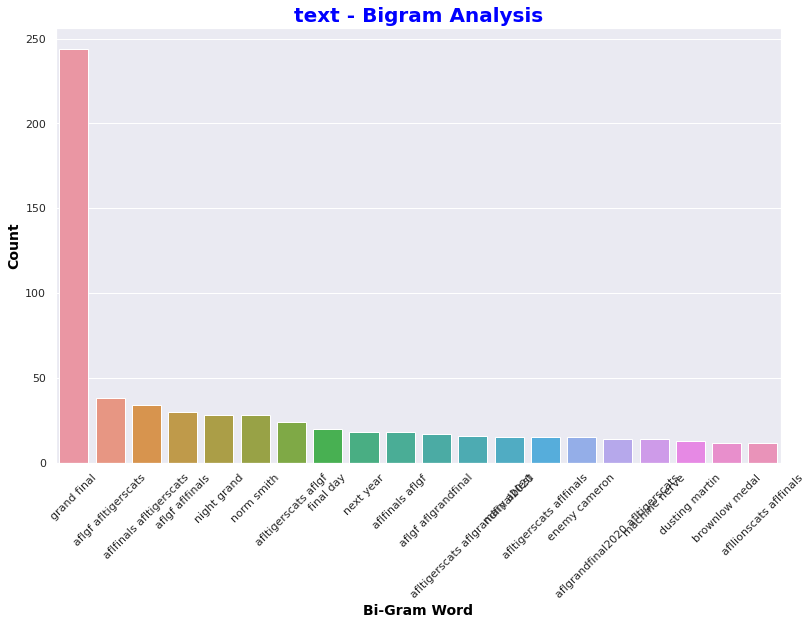

In [ ]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot( x="Bi-gram", y="Freq",data=bigrams_text_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)  # here rotation parameter shows the angle of your x-axis labels

plt.title('text - Bigram Analysis', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Bi-Gram Word', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Count', fontweight='bold', color = 'black', fontsize='14')  
#plt.savefig('text_Bigram_Analysis.png', dpi=800)
#files.download('text_Bigram_Analysis.png')
plt.show()

**Analysing Special worlds uisng Bigrams**

In [ ]:
new_bigrams_text_df= pd.concat([bigrams_text_df['Bi-gram'].str.split(' ', expand=True)], axis=1)
new_bigrams_text_df.columns=["word1", "word2"]

In [ ]:
#Bigrams related to "afltigerscats" term
new_bigrams_text_df.loc[new_bigrams_text_df['word2'] == 'afltigerscats']

,word1,word2
1,aflgf,afltigerscats
2,aflfinals,afltigerscats
15,aflgrandfinal2020,afltigerscats
38,aflgrandfinal,afltigerscats
115,motif,afltigerscats
210,final,afltigerscats
398,richmondtigers,afltigerscats
416,play,afltigerscats
472,see,afltigerscats
480,win,afltigerscats


### Trigrams

In [ ]:
#Most frequently occuring Tri-grams
def get_trigrams(corpus):
    vec1 = CountVectorizer(ngram_range=(3,3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [ ]:
trigrams_text = get_ngrams(df['text_lemmatized'].tolist(), ngram_range=(3, 3))

In [ ]:
trigrams_text_df = pd.DataFrame(trigrams_text)
trigrams_text_df.columns=["Tri-gram", "Freq"]

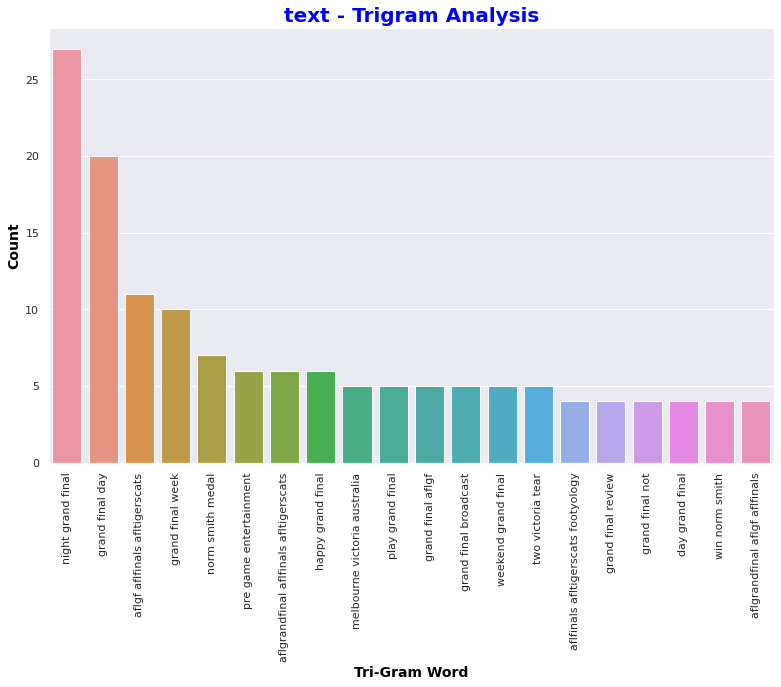

In [ ]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_text_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)

plt.title('text - Trigram Analysis', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Tri-Gram Word', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Count', fontweight='bold', color = 'black', fontsize='14')  
#plt.savefig('text_Trigram_Analysis.png', dpi=800)
#files.download('text_Trigram_Analysis.png')
plt.show()

**Analysing Special worlds uisng Trigrams**

In [ ]:
new_trigrams_text_df= pd.concat([trigrams_text_df['Tri-gram'].str.split(' ', expand=True)], axis=1)
new_trigrams_text_df.columns=["word1", "word2","word3"]

In [ ]:
#Trigrams related to "not" term
new_trigrams_text_df.loc[new_trigrams_text_df['word1'] == 'not']

,word1,word2,word3
164,not,want,see


## 11. Sentiment Analysis

### 11.01. Polarity

In [ ]:
# Extract sentiments from the tweets using polarity
df['polarity'] = df['text_lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity)


### 11.02. Subjectivity

In [ ]:
# Extract sentiments from the tweets using subjectivity
df['subjectivity'] = df['text_lemmatized'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

### 11.03.VADER

In [ ]:
# Extract sentiments from the tweets using VADER
df['VADER'] =df['text_lemmatized'].apply(lambda x: sia.polarity_scores(x)['compound'])

### 11.04. Display sentaences with respective sentiment value

In [ ]:

df[['text_lemmatized', 'polarity','subjectivity', 'VADER']].head(10)


,text_lemmatized,polarity,subjectivity,VADER
0,world successful sporting event prioritise to ...,0.275000,0.591667,0.8860
1,night grand final failure waste day lack cover...,-0.083333,0.540000,-0.3818
2,e written would say stuck right richmond,0.285714,0.535714,-0.2500
3,best thing last friday win silenced sophie loo...,0.260000,0.366667,0.8271
4,thrilling grand final feeling richmond neck am...,0.230000,0.980000,0.6249
5,must public holiday victoria farcethanks danie...,0.075000,0.616667,0.6908
6,first time year grand final contested two vict...,0.214286,0.673810,0.6486
7,let nip bud people want night grand final supp...,0.250000,1.000000,0.8442
8,thisisaustralia every kick every tackle every ...,0.250000,1.000000,0.6908
9,thisisaustralia every kick every tackle every ...,0.250000,1.000000,0.6908


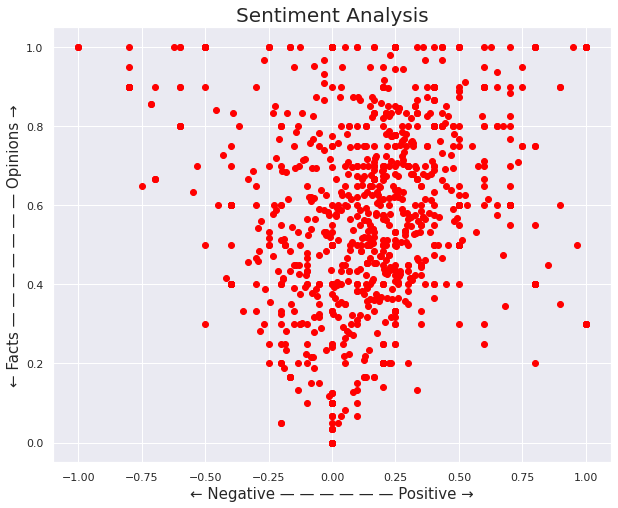

In [ ]:
# Let’s plot the results of polarity and Subjectivity together. 

plt.rcParams['figure.figsize'] = [10, 8]
for index, text_lemmatized in enumerate(df.index):
 x = df.polarity.loc[text_lemmatized]
 y = df.subjectivity.loc[text_lemmatized]
 plt.scatter(x, y, color='Red')
 
 
plt.title('Sentiment Analysis', fontsize = 20)
plt.xlabel('← Negative — — — — — — Positive →', fontsize=15)
plt.ylabel('← Facts — — — — — — — Opinions →', fontsize=15)
plt.show()



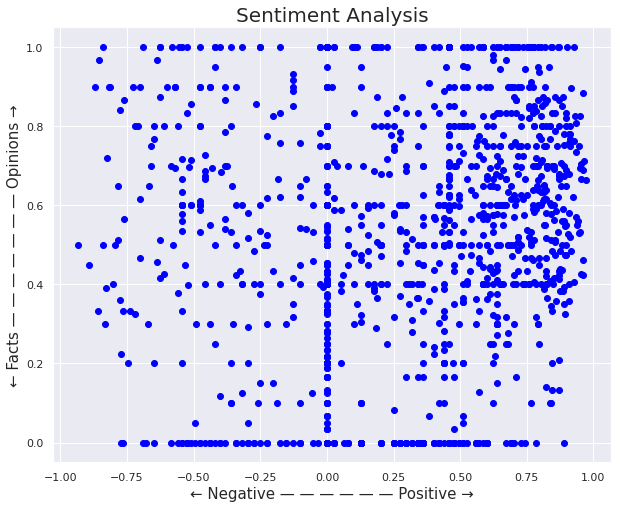

In [ ]:
# Let’s plot the results of VADER and Subjectivity together. 

plt.rcParams['figure.figsize'] = [10, 8]
for index, text_lemmatized in enumerate(df.index):
 x = df.VADER.loc[text_lemmatized]
 y = df.subjectivity.loc[text_lemmatized]
 plt.scatter(x, y, color='Blue')
 
 
plt.title('Sentiment Analysis', fontsize = 20)
plt.xlabel('← Negative — — — — — — Positive →', fontsize=15)
plt.ylabel('← Facts — — — — — — — Opinions →', fontsize=15)
plt.show()

In [ ]:
# Creating function for calculating positive, negative and neutral using polarity

def ratio(x):  
  if x > 0.5:
   return 'Extream Positive'
  elif x > 0:
   return 'Positive'
  elif x == 0:
   return 'Neutral'
  elif x > -0.50:
   return 'Negative'
  else:
   return 'Extream Negative'

df['Sentiment'] = df['polarity'].apply(ratio)

In [ ]:
#Count of sentiments

df['Sentiment'].value_counts()

Positive            607
Neutral             401
Negative            234
Extream Positive    109
Extream Negative     41
Name: Sentiment, dtype: int64

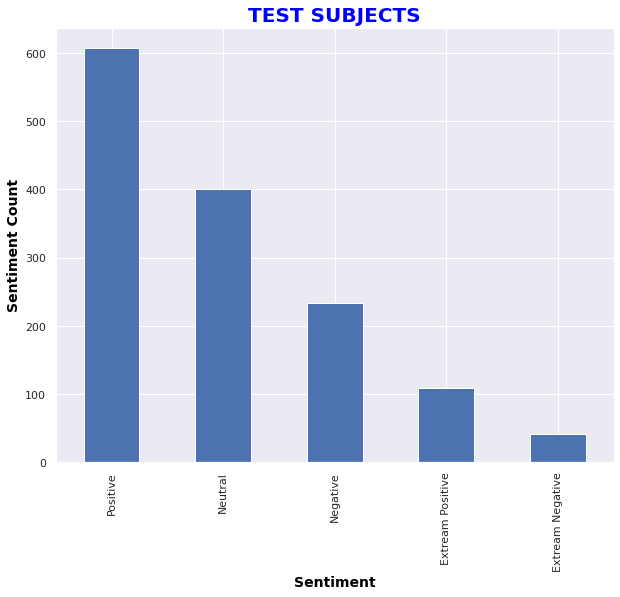

In [ ]:
#Plotting Sentiments

df['Sentiment'].value_counts().plot(kind = 'bar')

plt.title('TEST SUBJECTS', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Sentiment', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Sentiment Count', fontweight='bold', color = 'black', fontsize='14')  


#plt.savefig('Sentiment_Analysis2.png', dpi=800)
#files.download('Sentiment_Analysis2.png')
plt.show()


In [ ]:
# Creating function for calculating positive, negative and neutral using VADER

def ratio(x):  
  if x > 0.5:
   return 'Extream Positive'
  elif x > 0:
   return 'Positive'
  elif x == 0:
   return 'Neutral'
  elif x > -0.50:
   return 'Negative'
  else:
   return 'Extream Negative'

df['Sentiment2'] = df['VADER'].apply(ratio)

In [ ]:
#Count of sentiments

df['Sentiment2'].value_counts()

Extream Positive    472
Positive            352
Neutral             325
Negative            149
Extream Negative     94
Name: Sentiment2, dtype: int64

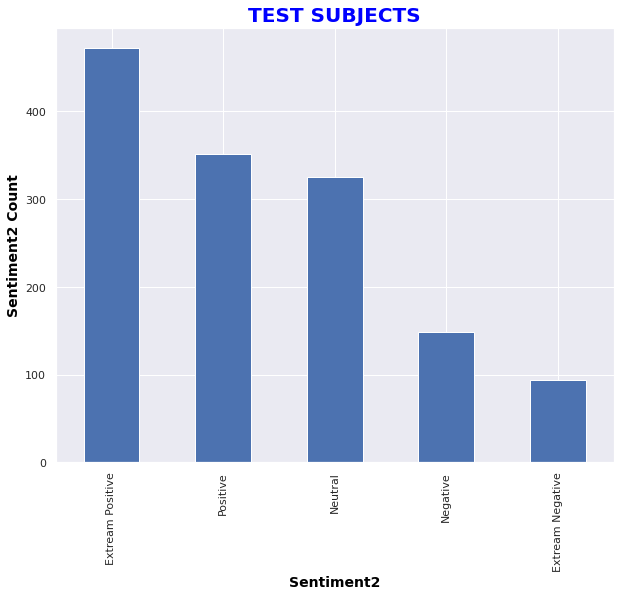

In [ ]:
#Plotting Sentiments

df['Sentiment2'].value_counts().plot(kind = 'bar')

plt.title('TEST SUBJECTS', fontweight='bold', color = 'blue', fontsize='20', horizontalalignment='center')
plt.xlabel('Sentiment2', fontweight='bold', color = 'black', fontsize='14', horizontalalignment='center')
plt.ylabel('Sentiment2 Count', fontweight='bold', color = 'black', fontsize='14')  


#plt.savefig('Sentiment_Analysis2.png', dpi=800)
#files.download('Sentiment_Analysis2.png')
plt.show()


## 12.Topic Modeling

### 12.01. Setting up the environment for LDA algorithm.

In [ ]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


Now we will create the text corpus.

In [ ]:
# Convert the tweets as the text corpus.
corpus = list(df['text_lemmatized'])

In [ ]:
# Tokanization
text_texts = [[word for word in str(document).split()] for document in corpus]

In [ ]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(text_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'text.dict'))

2020-10-25 06:07:03,450 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-10-25 06:07:03,483 : INFO : built Dictionary(4139 unique tokens: ['day', 'deal', 'dollar', 'else', 'event']...) from 1392 documents (total 15962 corpus positions)
2020-10-25 06:07:03,484 : INFO : saving Dictionary object under /tmp/text.dict, separately None
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-10-25 06:07:03,492 : INFO : saved /tmp/text.dict


In [ ]:
# Print the dictionary
print(dictionary.token2id)

{'day': 0, 'deal': 1, 'dollar': 2, 'else': 3, 'event': 4, 'everything': 5, 'exposure': 6, 'game': 7, 'gas': 8, 'got': 9, 'hence': 10, 'job': 11, 'know': 12, 'last': 13, 'like': 14, 'night': 15, 'number': 16, 'prioritise': 17, 'rating': 18, 'sporting': 19, 'successful': 20, 'there': 21, 'to': 22, 'world': 23, 'aflfinals': 24, 'aflgf': 25, 'bush': 26, 'coverage': 27, 'entertainment': 28, 'failure': 29, 'final': 30, 'football': 31, 'grade': 32, 'grand': 33, 'lack': 34, 'not': 35, 'waste': 36, 'e': 37, 'richmond': 38, 'right': 39, 'say': 40, 'stuck': 41, 'would': 42, 'written': 43, 'advantage': 44, 'another': 45, 'best': 46, 'chris': 47, 'critic': 48, 'friday': 49, 'home': 50, 'hope': 51, 'let': 52, 'looked': 53, 'motif': 54, 'scott': 55, 'silence': 56, 'silenced': 57, 'sophie': 58, 'thing': 59, 'unfair': 60, 'win': 61, 'year': 62, 'afltigerscats': 63, 'amp': 64, 'brought': 65, 'careerafl': 66, 'cellar': 67, 'could': 68, 'crushing': 69, 'ending': 70, 'fairy': 71, 'feeling': 72, 'heathen': 

In [ ]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in text_texts]

In [ ]:
# Corpus in machine readable format.
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1)], [(0, 1), (7, 1), (15, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)], [(37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1)], [(13, 2), (38, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)], [(24, 1), (30, 2), (33, 1), (38, 2), (50, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1)], [(30, 1), (33, 1), (68, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (

### 12.02. Generate the topic model

In [ ]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

2020-10-25 06:07:14,152 : INFO : collecting document frequencies
2020-10-25 06:07:14,153 : INFO : PROGRESS: processing document #0
2020-10-25 06:07:14,164 : INFO : calculating IDF weights for 1392 documents and 4138 features (15422 matrix non-zeros)


In [ ]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus]

### 12.03. Defining Topics Using LDA model

In [ ]:
total_topics = 10

In [ ]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2020-10-25 06:07:19,967 : INFO : using symmetric alpha at 0.1
2020-10-25 06:07:19,968 : INFO : using symmetric eta at 0.1
2020-10-25 06:07:19,971 : INFO : using serial LDA version on this node
2020-10-25 06:07:19,982 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 1392 documents, updating model once every 1392 documents, evaluating perplexity every 1392 documents, iterating 50x with a convergence threshold of 0.001000
2020-10-25 06:07:19,983 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.



In [ ]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=5)

[(0,
  '0.016*"aflgf" + 0.015*"game" + 0.014*"afltigerscats" + 0.013*"aflgrandfinal" + 0.011*"final"'),
 (1,
  '0.021*"final" + 0.020*"grand" + 0.016*"aflfinals" + 0.015*"aflgf" + 0.011*"year"'),
 (2,
  '0.014*"final" + 0.012*"afltigerscats" + 0.011*"grand" + 0.011*"game" + 0.010*"aflgf"'),
 (3,
  '0.020*"aflgf" + 0.015*"aflfinals" + 0.011*"afltigerscats" + 0.009*"aflgrandfinal" + 0.008*"afllionscats"'),
 (4,
  '0.020*"afltigerscats" + 0.011*"aflgf" + 0.011*"brownlow" + 0.010*"final" + 0.009*"richmond"'),
 (5,
  '0.019*"aflgf" + 0.017*"final" + 0.014*"grand" + 0.011*"aflfinals" + 0.009*"afltigerscats"'),
 (6,
  '0.018*"aflgf" + 0.014*"richmond" + 0.010*"aflfinals" + 0.010*"tiger" + 0.009*"year"'),
 (7,
  '0.015*"final" + 0.013*"grand" + 0.011*"aflgf" + 0.011*"afltigerscats" + 0.011*"year"'),
 (8,
  '0.020*"final" + 0.017*"grand" + 0.015*"aflgf" + 0.009*"good" + 0.009*"day"'),
 (9,
  '0.023*"final" + 0.021*"grand" + 0.015*"aflgf" + 0.012*"win" + 0.010*"afltigerscats"')]

### 12.04.Defining Topics Using NMF model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;

In [ ]:
from sklearn.preprocessing import normalize;

In [ ]:
from sklearn.decomposition import NMF;

In [ ]:
nmf_df = df['text_lemmatized']

In [ ]:
#obtain a Counts design matrix. Because the size of the matrix will be large, we can set the max_features to 5000.
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
x_counts = vectorizer.fit_transform(nmf_df);

In [ ]:
#set a TfIdf transformer, and transfer the counts with the model.
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [ ]:
#normalize the TfIdf values so each row has unit length.
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [ ]:
#obtain a NMF model.
model = NMF(n_components=total_topics, init='nndsvd');

In [ ]:
#fit the model
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [ ]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(total_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-6 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [ ]:
get_nmf_topics(model,6)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,afltigerscats,cat,final,that,dusty,afllionscats,tiger,aflgf,brownlow,richmond
1,aflgrandfinal2020,done,grand,shame,get,feeling,aflgrandfinal,aflfinals,nerve,win
2,hate,feeling,night,god,norm,chuckieeeeee,good,let,machine,feeling
3,grandfinal,mighty,day,sweet,smith,goatlett,dinner,better,medallist,final
4,tip,come,ever,master,u0001f44fu0001f3fdu0001f44fu0001f3fdu0001f44fu...,u0001f499u0001f90du0001f499u0001f90d,bloody,thank,hata,anyone
5,mary,thinking,week,gap,martin,game,played,journey,congratulation,going


## 13. Interactive Topic Analyzer With LDA

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

2020-10-25 06:07:57,417 : INFO : NumExpr defaulting to 2 threads.


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      32.420952   8.115230       1        1  38.693402
0       0.648955  71.707100       2        1  10.393419
6      71.019684   9.971006       3        1   9.073559
5       3.785981  33.185135       4        1   8.886759
2     -42.666500  -9.222070       5        1   7.401579
8      -3.621689 -43.526516       6        1   5.545131
1      -3.632402  -4.171708       7        1   5.002953
4     -36.584400  35.804413       8        1   5.001530
7      44.391380  50.615383       9        1   5.000920
9      40.235809 -31.591665      10        1   5.000748, topic_info=              Term       Freq      Total Category  logprob  loglift
30           final  15.000000  15.000000  Default  30.0000  30.0000
33           grand  12.000000  12.000000  Default  29.0000  29.0000
63   afltigerscats  15.000000  15.000000  Default  28.0000  28.0000
25           aflgf  23.000000  23.000000  Default  27.0000  27.0000
62            year   8.000000   8.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
14            like   0.266782   4.611545  Topic10  -5.5642   0.1457
0              day   0.285868   6.573990  Topic10  -5.4951  -0.1398
307            get   0.288070   6.907504  Topic10  -5.4875  -0.1816
142            one   0.272301   5.867071  Topic10  -5.5438  -0.0746
113           time   0.258472   7.722083  Topic10  -5.5959  -0.4015

[796 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
813       1  1.794559      230pm
702       1  0.452699       abbe
24        1  0.514950  aflfinals
24        2  0.064369  aflfinals
24        3  0.064369  aflfinals
...     ...       ...        ...
62        6  0.115018       year
62        7  0.115018       year
62        8  0.115018       year
62        9  0.115018       year
62       10  0.115018       year

[243 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 6, 3, 9, 2, 5, 8, 10])